# Feature selection and model comparison on MNIST dataset

### The objectives are as follows:
### 1- visualise the impact of dimensionality reduction on model generalisation
### The intuition is that less features will surely generalise the model more easily
### As a metric, we'll consider gap between train error and test error
### 2- Investigate models that can easily be interpreted so that hyper parameter tuning will be easier and benchmark against Convolutional Neural Networks 

In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#scikit 0.21.3
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from scipy import linalg

#### Using Kaggle Dataset Format

In [2]:
full_df = pd.read_csv('./data/train.csv')
full_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
def getVectorisedData(cur_dataframe):
    # extract observations and labels from dataframe
    y = cur_dataframe['label'].to_numpy().reshape(-1,1)
    x_cols = ['pixel' + str(i) for i in range(784)]
    x = cur_dataframe[x_cols].to_numpy().reshape(-1,784)
    return x, y

In [4]:
x_full, y_full = getVectorisedData(full_df)

#### For all models, we'll need train and test data

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size=0.2, random_state=42)

Define a metrics function getting calibration time, execution time on test set, train error and test error.
This will allow us to compare models later on

In [9]:
def getModelMetrics(curModel, x_train, y_train, x_test, y_test):
    # assumes curModel object implements fit, predict and score
    # this is true for all scikit learn classifiers
    # we can also implement our own model and use this function
    # provided our model class implements fit, predict and score methods
    
    startT = time.time()
    curModel.fit(x_train,y_train)
    calibT = time.time() - startT
    
    startT = time.time()
    y_test_predict = curModel.predict(x_test)
    execT = time.time() - startT
    
    train_error = 1-curModel.score(x_train, y_train.ravel())
    test_error = np.mean(y_test!=y_test_predict.reshape(-1,1))
    
    return train_error, test_error, calibT, execT

#### Start with a baseline model: no feature discovery/selection, logistic regression

In [21]:
clf_lr = LogisticRegression(penalty='l2', dual=False, tol=0.01, C=10.0
                         , fit_intercept=True, intercept_scaling=1, class_weight=None
                         , random_state=None, solver='sag', max_iter=100
                         , multi_class='multinomial', verbose=0, warm_start=False
                         , n_jobs=None, l1_ratio=None)

In [22]:
lr_metrics = getModelMetrics(clf_lr, x_train, y_train.ravel(), x_test, y_test)
print('model error train: {:.4f}'.format(lr_metrics[0]))
print('model error test: {:.4f}'.format(lr_metrics[1]))
print('calibration time: {:.4f}'.format(lr_metrics[2]))
print('test time: {:.4f}'.format(lr_metrics[3]))

model error train: 0.0545
model error test: 0.0804
calibration time: 94.1336
test time: 0.0394


#### PCA

In [12]:
# keeping all components so we don't have to rerun PCA everytime.
# we'll restrict columns later in our models by subsetting the arrays
# this also allows visualisation of cumulative explained variance

numComponents = x_train.shape[1]

pca = PCA(n_components=numComponents
        , copy=True
        , whiten=False
        , svd_solver='auto'
          , tol=0.0
          , iterated_power='auto'
          , random_state=None)

pca.fit(x_train)
eigenVecs = pca.components_
eigenVals = pca.singular_values_

Text(0, 0.5, 'cumulative explained variance')

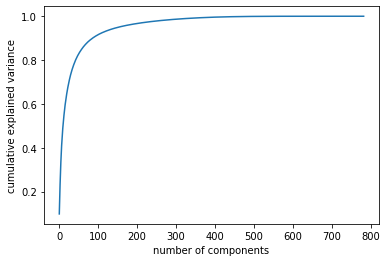

In [13]:
fig, ax = plt.subplots()
ax.plot([np.sum(pca.explained_variance_ratio_[:i]) for i in range(1,len(pca.explained_variance_ratio_))])
ax.set_xlabel('number of components')
ax.set_ylabel('cumulative explained variance')

### Conclusion: Initial problem dimension is 784 (28x28 pixel images)
### but the first 100 components explain over 90% of the variance

In [23]:
# with 80 components instead of 784 for the initial image, we already explain almost 90% of the variance
numSubComponents = 80
np.sum(pca.explained_variance_ratio_[:numSubComponents])

0.8912570752204803

In [24]:
x_train_pca = pca.transform(x_train)[:, :numSubComponents]
x_test_pca = pca.transform(x_test)[:, :numSubComponents]

### same Logistic regression but on reduced dimension

In [25]:
lr_pca_metrics = getModelMetrics(clf_lr, x_train_pca, y_train.ravel(), x_test_pca, y_test)
print('model error train: {:.4f}'.format(lr_pca_metrics[0]))
print('model error test: {:.4f}'.format(lr_pca_metrics[1]))
print('calibration time: {:.4f}'.format(lr_pca_metrics[2]))
print('test time: {:.4f}'.format(lr_pca_metrics[3]))

model error train: 0.0846
model error test: 0.0930
calibration time: 3.3879
test time: 0.0080


### Reducing the dimension does deteriorate the training error but the model generalises better since
### the gap between test and train error is lower than using all the features

### Visualising the geometry of our PCA to facilitate our choice of "geometric" classifiers

In [26]:
df_pca = pd.DataFrame(np.concatenate((y_train, x_train_pca), axis=1))
df_pca.columns=['label'] + ['c' + str(i) for i in range(numSubComponents)]

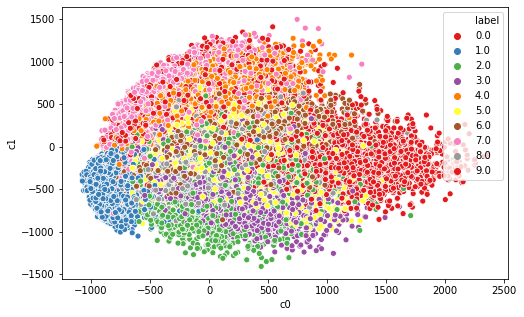

In [27]:
numberSubList = [i for i in range(10)]
df_pca_sub=df_pca[df_pca['label'].isin(numberSubList)]
#visualise first 2 principal components coordinates
plt.figure(figsize=(8,5))
sns.scatterplot(x='c0', y='c1', hue='label', data=df_pca_sub
                , legend='full', palette=sns.color_palette("Set1", n_colors=len(numberSubList)))

### There seems to be some clusters so we might be able to use a geometric classifier.
### But the overlaps might be important. To confirm this, we'll plot the first two coordinates in the new basis
### for pairwise labels

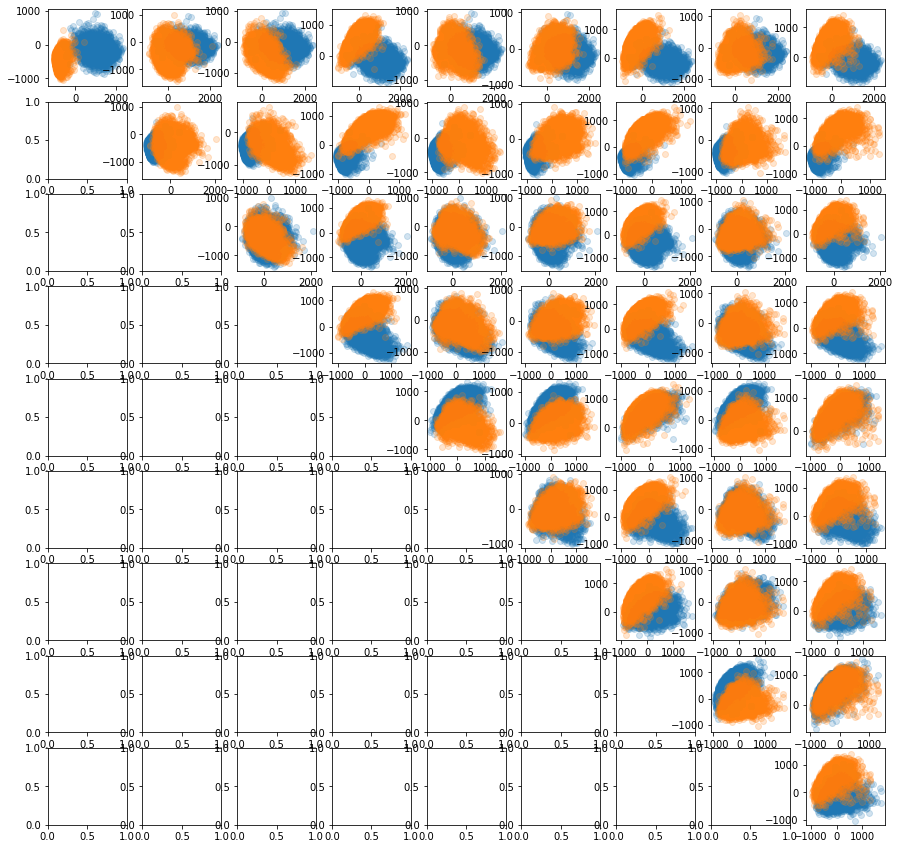

In [28]:
fig, ax = plt.subplots(9,9, figsize=(15,15))

for i in range(9):
    df_pca_1 = df_pca[df_pca['label']==i]
    for j in range(i+1,10):
        df_pca_2 = df_pca[df_pca['label']==j]
        ax[i,j-1].scatter(df_pca_1['c0'], df_pca_1['c1'], alpha=0.2)
        ax[i,j-1].scatter(df_pca_2['c0'], df_pca_2['c1'], alpha=0.2)

### SVM with rbf kernel on PCA

In [29]:
clf_svm = svm.SVC(kernel='rbf', gamma='scale', C=10, verbose=True, cache_size=1000)
svm_pca_metrics = getModelMetrics(clf_svm, x_train_pca, y_train.ravel(), x_test_pca, y_test)

[LibSVM]

In [30]:
print('model error train: {:.4f}'.format(svm_pca_metrics[0]))
print('model error test: {:.4f}'.format(svm_pca_metrics[1]))
print('calibration time: {:.4f}'.format(svm_pca_metrics[2]))
print('test time: {:.4f}'.format(svm_pca_metrics[3]))

model error train: 0.0001
model error test: 0.0177
calibration time: 35.9590
test time: 12.9343


### The model fits quite well and might be improved using grid search on gamma and C
### but due to complexity of the algorithm, grid search might be long
### we also notice that generalisation is better than logistic regression using all features but slightly worse than PCA + logistic regression

### Random Forest with PCA

In [31]:
clf_rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None
                                , min_samples_split=2, min_samples_leaf=1
                                , min_weight_fraction_leaf=0.0, max_features='sqrt'
                                , max_leaf_nodes=None, min_impurity_decrease=0.0
                                , min_impurity_split=None, bootstrap=True
                                , oob_score=False, n_jobs=None, random_state=50
                                , verbose=0, warm_start=False, class_weight=None)
rf_pca_metrics = getModelMetrics(clf_rf, x_train_pca, y_train.ravel(), x_test_pca, y_test)

In [32]:
print('model error train: {:.4f}'.format(rf_pca_metrics[0]))
print('model error test: {:.4f}'.format(rf_pca_metrics[1]))
print('calibration time: {:.4f}'.format(rf_pca_metrics[2]))
print('test time: {:.4f}'.format(rf_pca_metrics[3]))

model error train: 0.0000
model error test: 0.0540
calibration time: 54.3698
test time: 0.3945


### we're clearly overfitting. We need to prune the tree but this is not available in sklearn 0.21 (only available from 0.22)

# We'll now investigate an alternative to those standard methods: the Mahalanobis distance

Given an observation Y and observations $X_i$ that follow the same distribution, the Mahalanobis distance is defined as 
$d(X,Y) = (Y-mu)^T C^-1 (Y-mu)$ where mu the mean of X and C the covariance matrix of X
This distance is small if Y is drawn from the same distribution as the $X_i$
The idea is to calculate mu and C for each label and calculate this distance with this new observation. Our classifier will assign the new observation to the group with which the distance is smallest.
One of the advantages is that calibration of the model is quick (10 mean vectors and 10 inverse covariance matrices to compute) and prediction is obtained via matrix multiplications

We'll define a class mahalanobisClassifier that implements fit, predict and score so we can use our getModelMetrics function as if we were using a scikitlearn model

In [33]:
# in theory we only need to store the inverse covariance matrices
# but these matrices, though symmetric may suffer from numerical instability
# for this reason, we also store covariance matrices and their Cholesky decompositions
# so that instead of calculating z = C-1 * (x-mu)
# we can solve C z = x-mu
# using C = L Lt (cholesky decomposition)
# so we can first solve L y = x-mu in y
# and the solve Lt z = y in z
# this guarantees to find a solution

class mahalanobisClassifier:
    def __init__(self):
        self.labels = None
        self.means = None
        self.covs = None
        self.invcovs = None
        self.Lcovs = None # L lower triangular matrix \ L Lt = cov matrix
        
    def fit(self, x, y):
        self.labels = np.unique(y)
        self.means = []
        self.covs = []
        self.invcovs = []
        self.Lcovs = []
        temp = [[] for lab in self.labels]
        for i in range(x.shape[0]):
            temp[y[i]].append(x[i,:]) 
        for i in range(self.labels.shape[0]):
            self.means.append(np.mean(temp[i], axis=0))
            covMat = np.matmul(np.transpose(temp[i]-self.means[i]), temp[i]-self.means[i])
            #self.covs.append(np.matmul(np.transpose(temp[i]-self.means[i]), temp[i]-self.means[i]))
            self.invcovs.append(linalg.inv(covMat))
            #self.Lcovs.append(np.linalg.cholesky(covMat))
        
    def predict(self, x):
        # x matrix n x p with n observations, p features
        res = np.zeros(x.shape[0])
        for k in range(x.shape[0]):
            predLab = self.labels[0]
            #bestDist = self.mahalanobisDistance(x[k],self.means[0], self.covs[0])
            bestDist = self.mahalanobisDistance(x[k],self.means[0], self.invcovs[0])
            for i in range(self.labels.shape[0]):
                #curDist = self.mahalanobisDistance(x[k],self.means[i], self.covs[i])
                curDist = self.mahalanobisDistance(x[k],self.means[i], self.invcovs[i])
                if curDist < bestDist:
                    predLab = i
                    bestDist = curDist
            res[k] = predLab
        return res
        
    def score(self, x, y):
        y_pred = self.predict(x)
        return np.mean(y_pred==y)
    
    def mahalanobisDistance(self, x, mean, invcovMatrix):
        #res = np.matmul(np.transpose(x-mean), linalg.solve(covMatrix, x-mean, sym_pos=True))
        # y = cov-1 (x-mean)
        # cov y = x-mean
        # L Lt y = x-mean
        # L z = x-mean solve for z
        #z = linalg.solve_triangular(LcovMatrix, x-mean, lower=True)
        # Lt y = z solve for y
        #y = linalg.solve_triangular(np.transpose(LcovMatrix), z, lower=False)
        
        #res = np.matmul(np.transpose(x-mean), y)
        #res = np.matmul(np.transpose(x-mean), linalg.solve(covMatrix, x-mean, sym_pos=True))
        res = np.matmul(np.transpose(x-mean), np.matmul(invcovMatrix, x-mean))
        return res
        

In [34]:
clf_mah = mahalanobisClassifier()

In [35]:
x_train_pca = pca.transform(x_train)[:, :numSubComponents]
x_test_pca = pca.transform(x_test)[:, :numSubComponents]

In [36]:
mah_pca_metrics = getModelMetrics(clf_mah, x_train_pca, y_train.ravel(), x_test_pca, y_test)

In [37]:
print('model error train: {:.4f}'.format(mah_pca_metrics[0]))
print('model error test: {:.4f}'.format(mah_pca_metrics[1]))
print('calibration time: {:.4f}'.format(mah_pca_metrics[2]))
print('test time: {:.4f}'.format(mah_pca_metrics[3]))

model error train: 0.0586
model error test: 0.0661
calibration time: 0.2745
test time: 1.3662


### We get some interesting properties here:
### 1) gap between train and test errors is low, the model generalises well. If we can improve on train error, we'll surely improve test error
### 2) The algorithm is quick for calibration and evaluation.
### 3) We already do better than logistic regression without PCA on all criteria: test error and calibration time 

### We can consider using this model to choose the optimal number of components to use in our PCA.
### We'll then test this optimum on the other models

In [38]:
testErrors = []
numComps = [i for i in range(15, 60)]
for numC in numComps:
    numSubComponents = numC
    x_train_pca = pca.transform(x_train)[:, :numSubComponents]
    x_test_pca = pca.transform(x_test)[:, :numSubComponents]
    mah_pca_metrics = getModelMetrics(clf_mah, x_train_pca, y_train.ravel(), x_test_pca, y_test)
    testErrors.append(mah_pca_metrics[1])

optimal number of components: 36


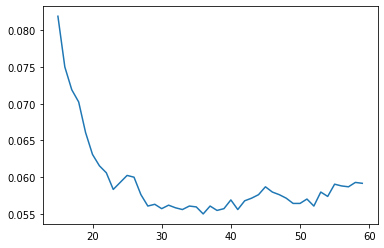

In [48]:
numSubComponents= numComps[np.argmin(testErrors)]
plt.plot(numComps, testErrors)
print('optimal number of components: {}'.format(numSubComponents))
x_train_pca = pca.transform(x_train)[:, :numSubComponents]
x_test_pca = pca.transform(x_test)[:, :numSubComponents]

### Rerunning Logistic Regression

In [45]:
lr_pca_metrics = getModelMetrics(clf_lr, x_train_pca, y_train.ravel(), x_test_pca, y_test)
print('model error train: {:.4f}'.format(lr_pca_metrics[0]))
print('model error test: {:.4f}'.format(lr_pca_metrics[1]))
print('calibration time: {:.4f}'.format(lr_pca_metrics[2]))
print('test time: {:.4f}'.format(lr_pca_metrics[3]))

model error train: 0.1058
model error test: 0.1107
calibration time: 1.6821
test time: 0.0042


### Rerunning SVM

In [46]:
svm_pca_metrics = getModelMetrics(clf_svm, x_train_pca, y_train.ravel(), x_test_pca, y_test)
print('model error train: {:.4f}'.format(svm_pca_metrics[0]))
print('model error test: {:.4f}'.format(svm_pca_metrics[1]))
print('calibration time: {:.4f}'.format(svm_pca_metrics[2]))
print('test time: {:.4f}'.format(svm_pca_metrics[3]))

[LibSVM]model error train: 0.0009
model error test: 0.0198
calibration time: 15.6686
test time: 5.4020


### Rerunning Random Forest

In [47]:
rf_pca_metrics = getModelMetrics(clf_rf, x_train_pca, y_train.ravel(), x_test_pca, y_test)
print('model error train: {:.4f}'.format(rf_pca_metrics[0]))
print('model error test: {:.4f}'.format(rf_pca_metrics[1]))
print('calibration time: {:.4f}'.format(rf_pca_metrics[2]))
print('test time: {:.4f}'.format(rf_pca_metrics[3]))

model error train: 0.0000
model error test: 0.0526
calibration time: 41.8094
test time: 0.3295
